<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---


# **Transformers**

#### **Morning contents/agenda**

1. What is a Transformer?

2. Applications and impact

3. Dissecting a Transformer:
  - Embeddings
  - Positional Encoding
  - Self-attention mechanism & multi-head attention
  - Dimensions, parallelisation and residual connections
  - Masked multi-head attention and other decoder differences
  - Regularisation and optimiser

4. Visualisation of transformers

5. `torch.nn.Transformer`

6. Extensions: Vision Transformers (ViTs) and multi-modal Transformers

#### **Learning outcomes**

1. Understand the transformer architecture based on the self-attention mechanism

2. Develop an intuition of what self-attention does by visualising attention maps

3. Increase a bit our awareness of the full Deep Learning landscape

<br>

#### **Afternoon contents/agenda**

1. Explore a pre-trained word embedding

2. Implement a multi-head attention layer

3. Build and train a compact transformer

#### **Learning outcomes**

1. Become familiar with some popular textual datasets and pre-trained embeddings

2. Gain hands-on experience on how the self-attention mechanism works in practice

3. Understand how transformers are structured and some of the heuristics that make them trainable


<br>

---

<br>

In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python

In [ ]:
!pip install torchtext==0.17.2 torchdata==0.7.1 torch==2.2.2 portalocker
!pip install pycm livelossplot torchinfo
%pylab inline

import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.vocab import GloVe, vocab
from torchtext.data.utils import get_tokenizer
from torchinfo import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Explore a pre-trained word embedding

### **1.1. Word embedding**

The first step in any text-processing neural network is to transform text values into numerical values that can be processed by our networks. As we have seen, using embeddings is an efficient way to achieve this for large vocabularies.

It is possible to design and train your own embeddings, but it is also possible to use embeddings that have already been trained by others.

For this exercise, we are going to be using [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/), which is conveniently pre-packaged as part of `torchtext`. You can find it in the documentation [here](https://pytorch.org/text/stable/vocab.html#glove).

Download the GloVe embeddings. I recommend you start with the 6B version with a dimensionality of 300:


In [ ]:
# Load GloVe through the torchtext interface
glove = GloVe(name='6B', dim=300)  # Download the GloVe embeddings
glove_vocab = vocab(glove.stoi)   # Extract the vocabulary
pretrained_embeddings = glove.vectors  # Extract the embedding vectors

.vector_cache/glove.6B.zip: 862MB [02:41, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:47<00:00, 8508.78it/s]


The vocabulary of this embedding does not have some special characters that are needed for general text datasets. We will add these manually.

In [ ]:
# Insert some special characters that are not present in the original vocabulary
# '<pad>' and '<unk>'
glove_vocab.insert_token('<unk>', 0)  # Insert <unk> at index 0
glove_vocab.insert_token('<pad>', 1)  # Insert <pad> at index 1
glove_vocab.set_default_index(0)      # Make index 0 the default for the vocabulary

# and add corresponding vectors to the embeddings
pretrained_embeddings = torch.cat((torch.mean(pretrained_embeddings, axis=0, keepdims=True),  # Mean of all vectors for <unk>
                                   torch.zeros(1, pretrained_embeddings.shape[1]),            # Zeros for <pad>
                                   pretrained_embeddings))                                    # All other vectors

To interact with the embeddings, let's create some utility functions:

In [ ]:
def get_word(word):
    """
    Get the embedding vector for a specific word.
    """
    return glove.vectors[glove.stoi[word]]

def closest(vec, n=10):
    """
    Find the closest words for a given vector.
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
    return sorted(all_dists, key=lambda t: t[1])[:n]

def print_tuples(tuples):
    """
    Print tuples with formatting.
    """
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

Using the functions above, find the closest vectors in the embedding to the word `dog`:

In [ ]:
print_tuples(closest(get_word('dog')))  # find closest vectors to the word 'dog'

(0.0000) dog
(4.3599) dogs
(5.1959) cat
(5.7008) pet
(5.8576) puppy
(6.2202) hound
(6.3971) pets
(6.4064) animal
(6.4334) __________________________________
(6.4496) canine


Perform the following operations on embeddings:

In [ ]:
# 'man' - 'king' + 'queen' = ?
closest_words = closest(get_word('man') - get_word('king') + get_word('queen'))

# Filter out original words
closest_words = [t for t in closest_words if t[0] not in ['king', 'man', 'queen']]

# Print result
print_tuples(closest_words[:5])

(5.9553) woman
(6.9806) girl
(7.2121) person
(7.4310) teenager
(7.4553) she


### **1.2. AG_NEWS dataset**

As part of the library `torchtext`, there are also a number of text datasets available to us. In this exercise, we are going to be using the [`AG_NEWS`](https://pytorch.org/text/stable/datasets.html#ag-news) dataset. This dataset contains extracts of news articles from around the world, labeled according to the type of news: `World`, `Sports`, `Business`, `Sci/Tech`.

Start by downloading the dataset:

In [ ]:
# Download the AG_NEWS dataset
agnews_train = AG_NEWS("./", split='train')
agnews_test = AG_NEWS("./", split='test')

To get this dataset into a format that can be diggested by a neural network, we will need to do a bit of work by using the `collate_fn` option of PyTorch's [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Complete the following code to process the dataset:

In [ ]:
# Get a tokenizer from torchtext
tokenizer = get_tokenizer('basic_english')

# Define how the dataset text and label are going to be pre-processed
text_pipeline = lambda x: [glove_vocab[token] for token in tokenizer(x)]  # Use the tokenizer to split the text and find each in the vocabulary
label_pipeline = lambda x: int(x) - 1                                     # Labels for this dataset start at 1

# A function to pre-process the text and label
def collate_batch(batch):
    label_list, text_list = [], []

    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))                              # Apply label process
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) # Apply text process
         text_list.append(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.int64)                    # Convert labels to tensor
    text_list = pad_sequence(sequences=text_list, batch_first=True, padding_value=glove_vocab['<pad>'])  # Ensure all text is padded to the same length

    return label_list.to(device), text_list.to(device)

# Select a subset of the training dataset to make it more lightweight
# and separate into training and validation
agnews_train_subset = random.choices(list(iter(agnews_train)), k=int(0.25*len(list(iter(agnews_train)))))
num_total = len(agnews_train_subset)
num_train = int(num_total * 0.95)
split_train, split_valid = random_split(agnews_train_subset, [num_train, num_total - num_train])

# Try creating some DataLoaders
train_loader = DataLoader(split_train, batch_size=64, num_workers=0, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid, batch_size=1000, num_workers=0, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(agnews_test, batch_size=1000, num_workers=0, shuffle=False, collate_fn=collate_batch)

### **1.3. Embedder class**

In order to use GloVe's pre-trained embedding, we will create an `Embedder` class that encapsulates PyTorch's [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

Fill in the embedder class:

In [ ]:
class Embedder(nn.Module):

    def __init__(self, pretrained_embeddings=None, embed_freeze=True):
        super().__init__()

        # Build nn.Embedding from pre-trained embeddings
        self.embeddings = nn.Embedding.from_pretrained(
            pretrained_embeddings.to(device),  # Make sure to send embeddings to the device
            freeze=embed_freeze                # Ensure the embeddings are not trained
        )

    def forward(self, x):
        embedded_text = self.embeddings(x)  # Apply embeddings
        return embedded_text

embedder = Embedder(pretrained_embeddings=pretrained_embeddings)

We can quickly test the embedder using an example from the training dataset:

In [ ]:
example_label, example_text = next(iter(train_loader))

embedded_text = embedder(example_text)
embedded_text.shape

torch.Size([64, 93, 300])

## 2. Implement a multi-headed attention layer

We are going to manually implement a multi-headed attention layer. Under normal circumstances, you would use PyTorch's predefined layers to build a Transformer, but just this once we will go over the implementation to understand how it works.

The self-attention mechanism is based around calculating a key, query, and value vector. These vectors are calculated using matrix multiplications (`nn.Linear`), but we will make the design more efficient by combining the key matrix, query matrix, and value matrix into a single linear layer.

Using the template below, implement a self-attention layer:

In [ ]:
class MultiheadedAttention(nn.Module):

    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads    # Divide dimension across heads
        self.scale = head_dim ** -0.5  # Scaling to be used for <q,v> dot product

        self.qkv = nn.Linear(dim, dim * 3)                 # 3*dim to account for q, k, v matrices
        self.attn_dropout = nn.Dropout(attention_dropout)  # Add dropout

        self.projection = nn.Linear(dim, dim)              # Add linear layer
        self.activation = nn.GELU()                        # And a GELU activation
        self.proj_dropout = nn.Dropout(projection_dropout) # Final dropout

    def forward(self, x):
        # Separate q, v, k matrices
        B, N, C = x.shape
        qkv = (
            self.qkv(x) # B, N, (3*C)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads) # B, N, 3(qkv), H(eads), embed_dim
            .permute(2, 0, 3, 1, 4)                                # 3, B, H(eads), N, emb_dim
            .reshape(3, B*self.num_heads, N, C // self.num_heads)  # 3, B*H(eads), N, emb_dim
        )
        q, k, v = torch.chunk(qkv, 3)                              # B, H*N, dim
        q, k, v = q.squeeze(0), k.squeeze(0), v.squeeze(0)         # Extract matrices

        # Calculate the dot product of q and k and softmax the result
        # B*H,N,dim x B*H,dim,N -> B*H,N,N
        attn = torch.bmm(q, k.transpose(-2, -1)) * self.scale # <q,k> / sqrt(d)
        attn = attn.softmax(dim=-1)                           # Softmax over embedding dim
        attn = self.attn_dropout(attn)                        # Dropout

        # Multiply the result by v and reshape appropriately
        # B*H, N, N
        x = (
            torch.bmm(attn, v)                                  # B*H,N,N x B*H,N,dim -> B*H,N,dim
            .reshape(B, self.num_heads, N, C // self.num_heads) # B, H, N, dim
            .transpose(1, 2)                                    # B, N, H, dim
            .reshape(B, N, C)                                   # B, N, (H*dim)
        )

        # Apply a linear operation
        x = self.projection(x)   # Apply linear layer
        x = self.activation(x)   # Apply activation
        x = self.proj_dropout(x) # Apply dropout

        return x

## 3. Build and train a compact transformer

Now that we have built our attention layer, we will use it to build a Transformer. In particular, we are going to design it using as inspiration the Compact Transformer architecture introduced in [this paper](https://arxiv.org/pdf/2104.05704).

The goal of the Compact Transformer design is to reduce the number of parameters needed to build and train transformers by using a concept called Sequence Pooling.

The [accompanying repository](https://github.com/SHI-Labs/Compact-Transformers) contains some code that we have used as inspiration for the implementation below.

To build the Compact Transformer we will need a number of building blocks: a `TextEncoder`, a `TransformerEncoderLayer`, and a `TransformerClassifier`.

### **3.1. The `TextEncoder`**

Let's start by building the `TextEncoder`, which will apply a 1D convolution to the output of the embedder:

In [ ]:
class TextEncoder(nn.Module):

    def __init__(self, kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_input_channels=50,
                 n_output_channels=768,
                 activation=None):

        super(TextEncoder, self).__init__()

        # Combine a 1D convolution with an optional activation and optional max pooling
        self.conv_layers = nn.Sequential(
            # Use a Conv2D to make a 1D convolution
            nn.Conv2d(1, n_output_channels,
                      kernel_size=(kernel_size, n_input_channels),
                      stride=(stride, 1),
                      padding=(padding, 0), bias=False),
            # Activation or identity
            nn.Identity() if activation is None else activation(),
        )

        # Initialise weights
        self.apply(self.init_weight)

    def forward(self, x):
        x = x.unsqueeze(1)               # Unsqueeze dimension 1
        x = self.conv_layers(x)          # Apply conv
        x = x.transpose(1, 3).squeeze(1) # Squeeze again
        return x

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

### **3.2. The `TransformerEncoderLayer`**

Next, a `TransformerEncoderLayer` will combine our multi-headed attention with a FFN. We will also add a number of training heuristics like [`nn.LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

In [ ]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, embed_dim=768, num_heads=8, dim_feedforward=2048,
                 dropout=0.1, attention_dropout=0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(embed_dim)  # Layer norm 1
        self.norm_2 = nn.LayerNorm(embed_dim)  # Layer norm 2

        # Multi-headed Attention
        self.MHA = MultiheadedAttention(
            embed_dim,
            num_heads,
            attention_dropout=attention_dropout,
            projection_dropout=dropout,
        )

        # FFN
        self.ff = nn.Sequential(
            # Linear layer + GELU activation + Dropout
            nn.Linear(embed_dim, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            # Linear layer + Dropout
            nn.Linear(dim_feedforward, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        mha = self.MHA(self.norm_1(x)) # Multi-headed attention

        x = x + mha                    # Residual connection (Add)
        x = self.norm_2(x)             # LayerNorm

        x2 = self.ff(x)                # FFN
        x = x + x2                     # Residual connection (Add)

        return x

### **3.3. The `TransformerClassifier`**

We will use a `TransformerClassifier` to concatenate multiple `TransformerEncoderLayer` and add the Sequence Pooling mechanism.

In [ ]:
class TransformerClassifier(nn.Module):

    def __init__(self,
                 embed_dim=768,		    # Embedding dim
                 num_layers=4,          # Number of transformer encoders
                 num_heads=8,           # Number of attention heads
                 attention_dropout=0.1, # Attention Dropout
                 dropout=0.1,           # (MHA) Projection Dropout
                 mlp_ratio=4,           # (MHA) Projection FF dimension
                 num_classes=4,         # Number of classes to classify
                 seq_pool=True          # Use sequence pooling?
        ):
        super().__init__()

        dim_feedforward = int(embed_dim * mlp_ratio)

        # Concatenate as many TransformerEncoderLayer as required
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderLayer(embed_dim=embed_dim,
                                                                           num_heads=num_heads,
                                                                           dim_feedforward=dim_feedforward,
                                                                           attention_dropout=attention_dropout,
                                                                           dropout=dropout)
                                                  for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)  # Layer norm

        # Sequential Pooling weights
        self.seq_pool = seq_pool
        self.attention_pool = nn.Linear(embed_dim, 1)

        # A final projection to the output classes
        self.mlp = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Add positional embedding
        x += self.sinusoidal_embedding(x.size(1), x.size(2)).to(device)

        # Apply TransformerEncoderLayer
        x = self.transformer_encoder(x)
        x = self.norm(x)

        # Apply Sequential Pooling
        if self.seq_pool:
            pool_x = self.attention_pool(x)                                 # Apply linear operation
            soft_pool_x = F.softmax(pool_x, dim=1)                          # Calculate softmax
            x = torch.matmul(soft_pool_x.transpose(-1, -2), x).squeeze(-2)  # Use the result to weight the information in x
        else:
            x = x[:, 0]

        # Final MLP
        x = self.mlp(x)

        return x

    @staticmethod
    def sinusoidal_embedding(n_channels, dim):
        pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                                for p in range(n_channels)])
        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])
        return pe.unsqueeze(0)

### **3.4. The full model**

Finally, we can combine the `Embedder` with the `TextEncoder` and the `TransformerClassifier` to build our model:

In [ ]:
class TextTransformer(nn.Module):

    def __init__(self, embed_dim=768, num_classes=4, patch_size=2,
                 vocab=glove_vocab, pretrained_embeddings=pretrained_embeddings, embed_freeze=True,
                 **kwargs):
        super(TextTransformer, self).__init__()

        word_embed_dim = pretrained_embeddings.shape[1]
        # Word embedder
        self.embedder = Embedder(pretrained_embeddings=pretrained_embeddings, embed_freeze=True)

        # Text encoder
        self.encoder = TextEncoder(
            n_input_channels=word_embed_dim,
            n_output_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
            activation=nn.GELU,
        )

        # Transformer classifier
        self.classifier = TransformerClassifier(
            embed_dim=embed_dim, num_classes=num_classes,
            dropout=0.1,
            attention_dropout=0.1,
            **kwargs
        )

    def forward(self, x):
        x = self.embedder(x)     # Apply embedder
        x = self.encoder(x)      # Apply encoder
        out = self.classifier(x) # Apply classifier
        return out

example_label, example_text = next(iter(train_loader))

model = TextTransformer(
    embed_dim=96, num_classes=4, patch_size=2,
    num_layers=1, num_heads=8, mlp_ratio=2, seq_pool=True,
    vocab=glove_vocab, pretrained_embeddings=pretrained_embeddings
).to(device)

summ = summary(model, input_data=example_text)
print(summ)

Layer (type:depth-idx)                             Output Shape              Param #
TextTransformer                                    [64, 4]                   --
├─Embedder: 1-1                                    [64, 84, 300]             --
│    └─Embedding: 2-1                              [64, 84, 300]             (120,000,600)
├─TextEncoder: 1-2                                 [64, 42, 96]              --
│    └─Sequential: 2-2                             [64, 96, 42, 1]           --
│    │    └─Conv2d: 3-1                            [64, 96, 42, 1]           57,600
│    │    └─GELU: 3-2                              [64, 96, 42, 1]           --
├─TransformerClassifier: 1-3                       [64, 4]                   --
│    └─Sequential: 2-3                             [64, 42, 96]              --
│    │    └─TransformerEncoderLayer: 3-3           [64, 42, 96]              74,784
│    └─LayerNorm: 2-4                              [64, 42, 96]              192
│    └─Linear: 

### **3.5. Define the loss and training loops**

It is common when training Transformers to use label smoothing Cross-Entropy as a loss. Label smoothing increases loss when the model is correct and decreases the loss when it is incorrect. This allows us not to punish the model as harshly when labels are incorrect.

We are not going to use label smoothing for this training, but we will leave the implementation below for reference. This implementation has been adapted from [this library](https://timm.fast.ai/loss.cross_entropy):

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()

        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def _compute_losses(self, x, target):
        log_prob = F.log_softmax(x, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss

    def forward(self, x, target):
        return self._compute_losses(x, target).mean()

### **3.6 Model training**

We define our train, validate, and test loops as usual:

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for y, X in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info
        y_hat = model(X)                  # forward pass
        loss = criterion(y_hat, y)        # compute loss
        loss.backward()                   # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(y_hat, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        optimizer.step()                  # perform a step of gradient descent

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for y, X in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            y_hat = model(X)                      # forward pass
            loss = criterion(y_hat, y)            # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(y_hat, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for y, X in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device) # data and labels to device
            y_hat = model(X)                  # forward pass and reshape tensor and get it ready to the fully connected layer
            y_pred = F.log_softmax(y_hat, dim=1).max(1)[1] # calculate prediction
            ys.append(y.cpu().numpy())        # save predictions
            y_preds.append(y_pred.cpu().numpy()) # save predictions

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

Let's define some hyperparameters:

In [ ]:
seed = 42 ## keep at that if you want to get almost the exact same results (down to numerical precision I guess)
lr = 1e-2
batch_size = 64
test_batch_size = 1000
n_epochs = 10

And we can finally train the model! Once you have trained the model, answer the following questions:

1. What is the impact of the sequence pooling on the training?
2. What is the impact of the number of heads and layers in our architecture?
3. What is the impact of using a different embedding?
4. How could you improve the network's performance?

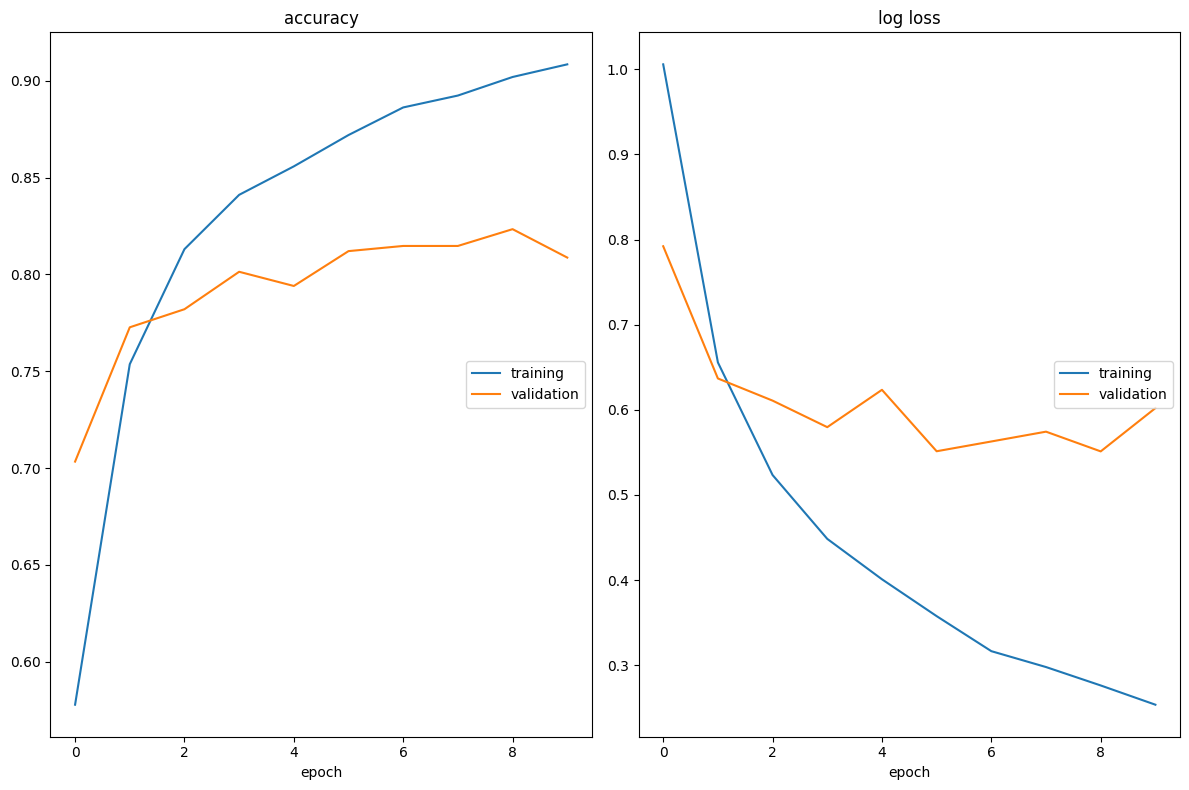

accuracy
	training         	 (min:    0.578, max:    0.908, cur:    0.908)
	validation       	 (min:    0.703, max:    0.823, cur:    0.809)
log loss
	training         	 (min:    0.254, max:    1.006, cur:    0.254)
	validation       	 (min:    0.551, max:    0.792, cur:    0.602)
0.6019893288612366


In [ ]:
# Create model and send to device
model = TextTransformer(
    embed_dim=96, num_classes=4, patch_size=2,
    num_layers=1, num_heads=8, mlp_ratio=2, seq_pool=True,
    vocab=glove_vocab, pretrained_embeddings=pretrained_embeddings
).to(device)

set_seed(seed)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # instantiate the optimizer
criterion = nn.CrossEntropyLoss()                         # instantiate the criterion

# Create data loaders
train_loader = DataLoader(split_train, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid, batch_size=test_batch_size, num_workers=0, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(agnews_test, batch_size=test_batch_size, num_workers=0, shuffle=False, collate_fn=collate_batch)

liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

<br>

---

<br>